# Computer Vision Homework 02 - Panoramas, Image Features, and Calibration

Contact: David C. Schedl (david.schedl@fh-hagenberg.at)

Note: this is the starter pack for the **Visual Computing** homework. You do not need to use this template!

## Task:
This exercise features a variety of tasks, ideas and algorithms we covered previously. The goal is to get familiar with the concepts and to apply them to a real-world problem.
Therefore, for this exercise you get uncalibrated image pairs of thermal and RGB images of multiple scenes recorded with one of our BAMBI drones. 

Based on the images you should try to solve (some of) the following tasks and answer the following questions:
* **Panorama stitching:** Create a panorama image from the RGB images. You can use the `ellipse` or `FH3` scenes for this task. Can you compute a panorama from the thermal images? 
* **Image features (thermal to RGB):** Detect and match image features from the thermal to the RGB images. How many features do you find? Which feature descriptors are suitable for this task? Which scenes work and which don't? How can you measure the quality of the matches?
* **Camera Calibration:** Calibrate the camera with the thermal and/or RGB images. How many images do you need? Does it work at all? How well does the calibration work? How can you measure the quality of the calibration?
* **Extrinsic Estimation:** Try to estimate the rotation and translation of the drone. How well does it work? How can you measure the quality of the estimation? 

Note that the cameras are mounted on a gimbal and therefore the cameras are perfectly aligned (no rotation and assume no translation between the thermal and RGB camera).

Use feature descriptors to find correspondences and match them. Matching can be done with the nearest neighbour distance or any other strategy. 
To estimate the extrinsic parameters, you can use OpenCV's [`findEssentialMat`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad245d60e64d0c1270dbfd0520847bb87), [`findFundamentalMat`](https://docs.opencv.org/4.x/d9/d0c/group__calib3d.html#gad245d60e64d0c1270dbfd0520847bb87), or any similar function. 


**Further comments/hints:**

*   The thermal camera has severe distortions. Don't worry too much about imprecisions. 
*   If you have troubles with the intrinsic calibration I provide a ground truth calibration for both cameras below. However, try to it without the ground truth first.
*   Think about the problem 🤔, solve it, and critically evaluate your solution.
*   You can downscale the RGB images to speed up the computation.
*   Summarize your ideas and findings in the report. 



**Have fun!** 😸


## Initialization

Let's import useful libraries, first. 
Then download some images or additional python scripts with `curl`.
Let's define utility functions to display images, in Jupyter Notebooks. OpenCV's `imshow` does not work and matplotlib's `imshow` needs special treatment due to color channel handling (RGB vs. BGR)

In [1]:
def download_cv_dataset(dataset: str, extract_to: str = "./data"):
    import os

    # change the current working directory
    old_working_dir = os.getcwd()
    os.chdir(extract_to)
    try:
        # check if the file exists
        if not os.path.exists(os.path.join(extract_to, dataset)):
            !curl -LJO "https://raw.githubusercontent.com/Digital-Media/cv_data/main/{dataset}" --silent
        import zipfile

        with zipfile.ZipFile(dataset, "r") as zip_ref:
            zip_ref.extractall(".")
    except Exception as e:
        print(f"Error: Please check if the dataset {dataset} exists.")
        # print the error message
        print(e)
    finally:
        # change back to the original working directory
        os.chdir(old_working_dir)


download_cv_dataset("thermal-rgb_ellipse.zip")
download_cv_dataset("thermal-rgb_FH3.zip")
download_cv_dataset("thermal-rgb_forest.zip")
download_cv_dataset("thermal-rgb_hut.zip")

In [2]:
# read the images from the dataset folder

import glob  # library for loading images from a directory
import cv2  # library for image processing

# use one of the following datasets: "FH3", "forest", "hut"
def read_images(dataset: str):
    # get the list of images from the dataset folder
    T_img_files = glob.glob(f"./data/{dataset}/T_*.png")
    W_img_files = glob.glob(f"./data/{dataset}/W_*.png")
    # assert that the number of images is the same
    assert len(T_img_files) == len(W_img_files)

    # if there are no images, raise an error
    if len(T_img_files) == 0:
        raise ValueError(f"No images found in the {dataset} folder.")

    T_imgs = []
    W_imgs = []

    for i in range(len(T_img_files)):
        # read the images
        T_img = cv2.imread(T_img_files[i])
        W_img = cv2.imread(W_img_files[i])
        # add the images to a list
        W_imgs.append(W_img)
        T_imgs.append(T_img)

    return {"Thermal": T_imgs, "RGB": W_imgs}


# read the images
images = read_images("ellipse")

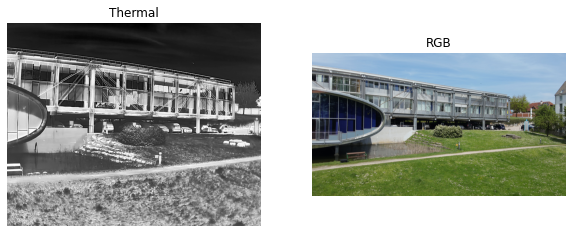

In [3]:
# SETUP
if "google.colab" in str(get_ipython()):
    # install a newer opencv version on Colab. The older OpenCV versions do not support SIFT!
    !pip install opencv-contrib-python>=4.5.*

# import the libraries we use
import os
import cv2  # openCV
import numpy as np
import matplotlib.pyplot as plt

# utility function(s)
def imshow(image, *args, **kwargs):
    """A replacement for cv2.imshow() for use in Jupyter notebooks using matplotlib.

    Args:
      image : np.ndarray. shape (N, M) or (N, M, 1) is an NxM grayscale image. shape
        (N, M, 3) is an NxM BGR color image.
    """
    if len(image.shape) == 3:
        # Height, width, channels
        # Assume BGR, do a conversion
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    # Draw the image
    plt.imshow(image, *args, **kwargs)
    # We'll also disable drawing the axes and tick marks in the plot, since it's actually an image
    plt.axis("off")
    # Make sure it outputs
    # plt.show()


plt.figure(figsize=(10, 10))
plt.subplot(121), plt.title("Thermal")
imshow(images["Thermal"][0])
plt.subplot(122), plt.title("RGB")
imshow(images["RGB"][0])

In [4]:
gt_calibrations = {
    "Thermal": {
        "K": [
            [1523.7602359891657, 0.0, 618.0480346862191],
            [0.0, 1491.3570424347292, 507.1000881569456],
            [0.0, 0.0, 1.0],
        ],
        "dist": [
            [
                -0.3880250851012345,
                0.3744059275961452,
                0.0010497689153120373,
                0.00011610446402566044,
                0.0,
            ]
        ],
    },
    "RGB": {
        "K": [
            [2888.178324915765, 0.0, 1929.0179499431672],
            [0.0, 2819.3160759551897, 1070.7804294784548],
            [0.0, 0.0, 1.0],
        ],
        "dist": [
            [
                0.13853585738444427,
                -0.25508562557544706,
                0.00020336601637138113,
                -0.0009057472383396885,
                0.0,
            ]
        ],
    },
}

<Figure size 1440x576 with 0 Axes>

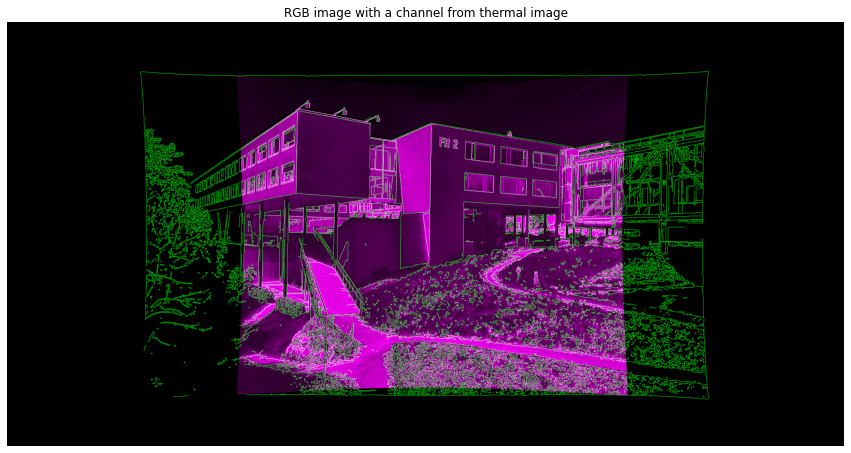

In [13]:
# make an interactive plot
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

dst_size = (2024, 1024)
f = min(*dst_size)
new_camera_matrix = np.array(
    [[f, 0.0, dst_size[0] / 2 - 0.5], [0.0, f, dst_size[1] / 2 - 0.5], [0.0, 0.0, 1.0]]
)


def overlay_images(
    images, calibrations, selected_img_id=0, show_individual_images=False
):
    plt.figure(figsize=(20, 8))
    for i, camera in enumerate(images.keys()):
        # calib = saver.get(get_resource("calibration.db"), drone_name, camera, normalize_calibration=True)
        calib = calibrations.get(camera)
        assert calib is not None

        camera_matrix = np.array(calib["K"])
        # k1, k2, p1, p2, k3
        dist_coefs = np.array(calib["dist"])

        if selected_img_id >= len(images[camera]):
            print("WARNING: selected_img_id is out of range.")
            selected_img_id = len(images[camera]) - 1

        img = images[camera][selected_img_id]

        # remove the the lens distortions
        mapx, mapy = cv2.initUndistortRectifyMap(
            camera_matrix, dist_coefs, None, new_camera_matrix, dst_size, cv2.CV_32FC1
        )
        dst = cv2.remap(img, mapx, mapy, cv2.INTER_CUBIC)
        # print(dst_T.shape)

        if show_individual_images:
            plt.subplot(1, len(calibrations), i + 1)
            imshow(dst, cmap="gray")
            plt.title(f"undistorted {camera} image")

        if camera == "RGB":
            # apply an edge detector on the wide image
            dst = cv2.Canny(dst.copy(), 100, 200)
            rgb_img_edge = cv2.cvtColor(dst, cv2.COLOR_GRAY2RGB)
        else:
            thermal_img = dst.copy()
            cmp_img = thermal_img.copy()
    plt.show()  # show the images

    cmp_img[:, :, 1] = rgb_img_edge[:, :, 1]  # copy a channel from the thermal image

    plt.figure(figsize=(15, 8))
    imshow(cmp_img, cmap="gray")
    plt.title(f"RGB image with a channel from thermal image")
    plt.show()


overlay_images(images, gt_calibrations, 6)